In [4]:
#@title Imports
import matplotlib.pyplot as plt
import os
# import json
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torchvision.transforms import Resize, CenterCrop, Normalize, Compose
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm  
from pytorch_fid import fid_score
from torchmetrics.image.inception import InceptionScore
from torchvision.transforms import functional as TF
from PIL import Image
import scipy

## Loading Dataset

In [5]:
transform = transforms.Compose([
  transforms.Grayscale(),
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

data_root = "chest_xray"

train_dataset = datasets.ImageFolder(root=f"{data_root}/train", transform=transform)
val_dataset   = datasets.ImageFolder(root=f"{data_root}/val", transform=transform)
test_dataset  = datasets.ImageFolder(root=f"{data_root}/test", transform=transform)

train_loader = DataLoader(
  train_dataset,
  batch_size=32,
  shuffle=True,
  pin_memory=False,
  num_workers=2
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 5216
Validation samples: 16
Test samples: 624


#### Viewing Samples from Dataset

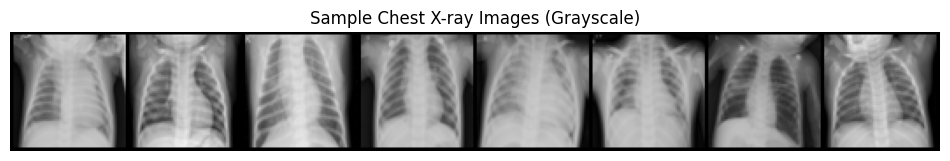

In [7]:
images, _ = next(iter(train_loader))

grid_img = torchvision.utils.make_grid(images[:8], nrow=8)

plt.figure(figsize=(12, 2))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.title('Sample Chest X-ray Images (Grayscale)')
plt.show()

## Setting up Vanilla VAE

In [8]:
class VanillaVAE(nn.Module):
  def __init__(self, latent_dim=16):
    super().__init__()
    # encoder: 64x64 -> 32x32 -> 16x16 -> 8x8
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 4, 2, 1),   # -> (16, 32, 32)
      nn.ReLU(),
      nn.Conv2d(16, 32, 4, 2, 1),  # -> (32, 16, 16)
      nn.ReLU(),
      nn.Conv2d(32, 64, 4, 2, 1),  # -> (64, 8, 8)
      nn.ReLU(),
      nn.Flatten()
    )

    self.flatten_dim = 64 * 8 * 8  

    self.fc_mu     = nn.Linear(self.flatten_dim, latent_dim)
    self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)

    self.decoder = nn.Sequential(
      nn.Unflatten(1, (64, 8, 8)),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, 4, 2, 1),  # -> (32, 16, 16)
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, 4, 2, 1),  # -> (16, 32, 32)
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 4, 2, 1),   # -> (1, 64, 64)
      nn.Sigmoid()
    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    h = self.encoder(x)
    mu, logvar = self.fc_mu(h), self.fc_logvar(h)
    z = self.reparameterize(mu, logvar)
    recon = self.decoder(self.fc_decode(z))
    return recon, mu, logvar

  def loss_function(self, recon, x, mu, logvar, beta=1.0):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum') / x.size(0)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total = recon_loss + beta * kld
    return total, recon_loss, kld

## Training Loop

In [9]:
def validate_vae(model, dataloader, device):
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for x, _ in dataloader:
      x = x.to(device)
      recon, mu, logvar = model(x)
      total_loss, _, _ = model.loss_function(recon, x, mu, logvar)
      val_loss += total_loss.item()
  return val_loss / len(dataloader.dataset)

In [ ]:
def train_vae(model, train_loader, val_loader, device, epochs=10, lr=1e-3, save_path="vae_checkpoint.pt"):

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.to(device)

  train_losses, val_losses = [], []
  recon_losses, kld_losses = [], []
  best_val_loss = float('inf')

  num_train_samples = len(train_loader.dataset)

  try:
    for epoch in range(1, epochs + 1):
      model.train()
      total_loss, total_recon, total_kld = 0, 0, 0

      loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
      for x, _ in loop:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, recon_loss, kld_loss = model.loss_function(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kld += kld_loss.item()

        loop.set_postfix(loss=loss.item() / x.size(0))  # Normalize for display

      avg_train_loss = total_loss / num_train_samples
      avg_recon_loss = total_recon / num_train_samples
      avg_kld_loss   = total_kld / num_train_samples
      avg_val_loss   = validate_vae(model, val_loader, device)

      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)
      recon_losses.append(avg_recon_loss)
      kld_losses.append(avg_kld_loss)

      print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.2f}, Recon: {avg_recon_loss:.2f}, "
            f"KLD: {avg_kld_loss:.2f}, Val: {avg_val_loss:.2f}")

      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")

  except Exception as e:
    print(f"Training crashed: {e}")
    torch.save(model.state_dict(), "vae_crash_backup.pt")
    print("Model state saved to vae_crash_backup.pt")

  return train_losses, val_losses, recon_losses, kld_losses

In [25]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = VanillaVAE(latent_dim=32).to(device)
print(f"Using device: {device}")

Using device: mps


In [12]:
train_losses, val_losses, recon_losses, kld_losses = train_vae(model, train_loader, val_loader, device, epochs=50)

Epoch 1 | Train Loss: 79.75, Recon: 79.25, KLD: 0.50, Val: 147.48
Saved best model to vae_checkpoint.pt


Epoch 2 | Train Loss: 76.34, Recon: 75.64, KLD: 0.70, Val: 146.03
Saved best model to vae_checkpoint.pt


Epoch 3 | Train Loss: 75.85, Recon: 75.15, KLD: 0.69, Val: 145.58
Saved best model to vae_checkpoint.pt


Epoch 4 | Train Loss: 75.55, Recon: 74.85, KLD: 0.70, Val: 144.89
Saved best model to vae_checkpoint.pt


Epoch 5 | Train Loss: 75.36, Recon: 74.66, KLD: 0.70, Val: 144.55
Saved best model to vae_checkpoint.pt


Epoch 6 | Train Loss: 75.24, Recon: 74.53, KLD: 0.71, Val: 144.34
Saved best model to vae_checkpoint.pt


Epoch 7 | Train Loss: 75.16, Recon: 74.45, KLD: 0.71, Val: 144.26
Saved best model to vae_checkpoint.pt


Epoch 8 | Train Loss: 75.10, Recon: 74.39, KLD: 0.72, Val: 144.24
Saved best model to vae_checkpoint.pt


Epoch 9 | Train Loss: 75.07, Recon: 74.35, KLD: 0.72, Val: 143.97
Saved best model to vae_checkpoint.pt


Epoch 10 | Train Loss: 75.02, Recon: 74.30, KLD: 0.72, Val: 144.17


Epoch 11 | Train Loss: 74.98, Recon: 74.26, KLD: 0.72, Val: 143.89
Saved best model to vae_checkpoint.pt


Epoch 12 | Train Loss: 74.96, Recon: 74.23, KLD: 0.72, Val: 143.85
Saved best model to vae_checkpoint.pt


Epoch 13 | Train Loss: 74.95, Recon: 74.22, KLD: 0.73, Val: 143.85


Epoch 14 | Train Loss: 74.93, Recon: 74.21, KLD: 0.73, Val: 143.73
Saved best model to vae_checkpoint.pt


Epoch 15 | Train Loss: 74.90, Recon: 74.17, KLD: 0.73, Val: 143.76


Epoch 16 | Train Loss: 74.89, Recon: 74.15, KLD: 0.73, Val: 143.84


Epoch 17 | Train Loss: 74.87, Recon: 74.14, KLD: 0.73, Val: 143.67
Saved best model to vae_checkpoint.pt


Epoch 18 | Train Loss: 74.85, Recon: 74.12, KLD: 0.73, Val: 143.61
Saved best model to vae_checkpoint.pt


Epoch 19 | Train Loss: 74.84, Recon: 74.10, KLD: 0.73, Val: 143.73


Epoch 20 | Train Loss: 74.83, Recon: 74.10, KLD: 0.73, Val: 143.70


Epoch 21 | Train Loss: 74.82, Recon: 74.09, KLD: 0.73, Val: 143.72


Epoch 22 | Train Loss: 74.81, Recon: 74.07, KLD: 0.73, Val: 143.63


Epoch 23 | Train Loss: 74.80, Recon: 74.07, KLD: 0.73, Val: 143.77


Epoch 24 | Train Loss: 74.80, Recon: 74.07, KLD: 0.73, Val: 143.69


Epoch 25 | Train Loss: 74.79, Recon: 74.06, KLD: 0.73, Val: 143.75


Epoch 26 | Train Loss: 74.78, Recon: 74.04, KLD: 0.74, Val: 143.56
Saved best model to vae_checkpoint.pt


Epoch 27 | Train Loss: 74.77, Recon: 74.03, KLD: 0.74, Val: 143.67


Epoch 28 | Train Loss: 74.76, Recon: 74.02, KLD: 0.74, Val: 143.70


Epoch 29 | Train Loss: 74.75, Recon: 74.01, KLD: 0.74, Val: 143.52
Saved best model to vae_checkpoint.pt


Epoch 30 | Train Loss: 74.75, Recon: 74.02, KLD: 0.74, Val: 143.65


Epoch 31 | Train Loss: 74.75, Recon: 74.01, KLD: 0.74, Val: 143.64


Epoch 32 | Train Loss: 74.74, Recon: 74.00, KLD: 0.74, Val: 143.46
Saved best model to vae_checkpoint.pt


Epoch 33 | Train Loss: 74.73, Recon: 73.99, KLD: 0.74, Val: 143.55


Epoch 34 | Train Loss: 74.74, Recon: 74.00, KLD: 0.74, Val: 143.47


Epoch 35 | Train Loss: 74.72, Recon: 73.99, KLD: 0.74, Val: 143.60


Epoch 36 | Train Loss: 74.72, Recon: 73.98, KLD: 0.74, Val: 143.83


Epoch 37 | Train Loss: 74.71, Recon: 73.97, KLD: 0.74, Val: 143.48


Epoch 38 | Train Loss: 74.71, Recon: 73.96, KLD: 0.74, Val: 143.46


Epoch 39 | Train Loss: 74.70, Recon: 73.96, KLD: 0.74, Val: 143.40
Saved best model to vae_checkpoint.pt


Epoch 40 | Train Loss: 74.70, Recon: 73.96, KLD: 0.74, Val: 143.54


Epoch 41 | Train Loss: 74.70, Recon: 73.96, KLD: 0.74, Val: 143.46


Epoch 42 | Train Loss: 74.69, Recon: 73.95, KLD: 0.74, Val: 143.63


Epoch 43 | Train Loss: 74.69, Recon: 73.95, KLD: 0.74, Val: 143.65


Epoch 44 | Train Loss: 74.68, Recon: 73.94, KLD: 0.74, Val: 143.46


Epoch 45 | Train Loss: 74.69, Recon: 73.94, KLD: 0.74, Val: 143.53


Epoch 46 | Train Loss: 74.68, Recon: 73.94, KLD: 0.74, Val: 143.52


Epoch 47 | Train Loss: 74.68, Recon: 73.93, KLD: 0.75, Val: 143.41


Epoch 48 | Train Loss: 74.67, Recon: 73.93, KLD: 0.74, Val: 143.38
Saved best model to vae_checkpoint.pt


Epoch 49 | Train Loss: 74.67, Recon: 73.93, KLD: 0.74, Val: 143.49


Epoch 50 | Train Loss: 74.67, Recon: 73.92, KLD: 0.74, Val: 143.48


## Evaluation

In [13]:
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=4096, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=32, bias=True)
  (fc_decode): Linear(in_features=32, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(64, 8, 8))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [27]:
model.load_state_dict(torch.load("vae_checkpoint.pt", map_location=device))
model.eval()  # set to evaluation mode

VanillaVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=4096, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=32, bias=True)
  (fc_decode): Linear(in_features=32, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(64, 8, 8))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

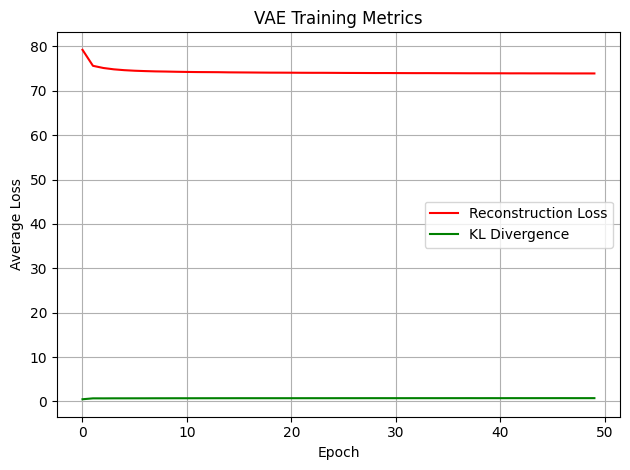

In [28]:
plt.plot(recon_losses, label="Reconstruction Loss", color='r')
plt.plot(kld_losses, label="KL Divergence", color='g')

plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("VAE Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

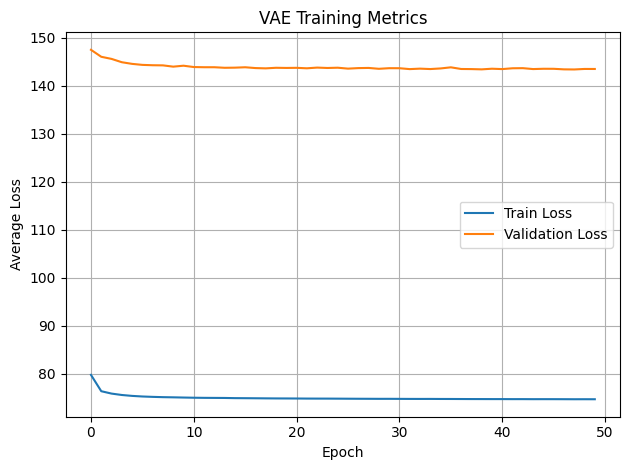

In [15]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("VAE Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

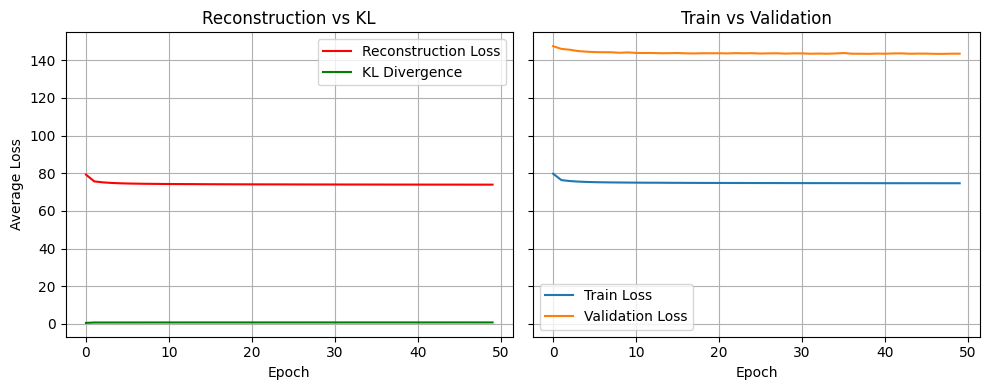

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot KL + Recon
axs[0].plot(recon_losses, label="Reconstruction Loss", color="red")
axs[0].plot(kld_losses, label="KL Divergence", color="green")
axs[0].set_title("Reconstruction vs KL")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Average Loss")
axs[0].legend()
axs[0].grid(True)

# Plot Train + Val
axs[1].plot(train_losses, label="Train Loss")
axs[1].plot(val_losses, label="Validation Loss")
axs[1].set_title("Train vs Validation")
axs[1].set_xlabel("Epoch")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("vae_training_metrics_side_by_side.png")

## Generating Samples

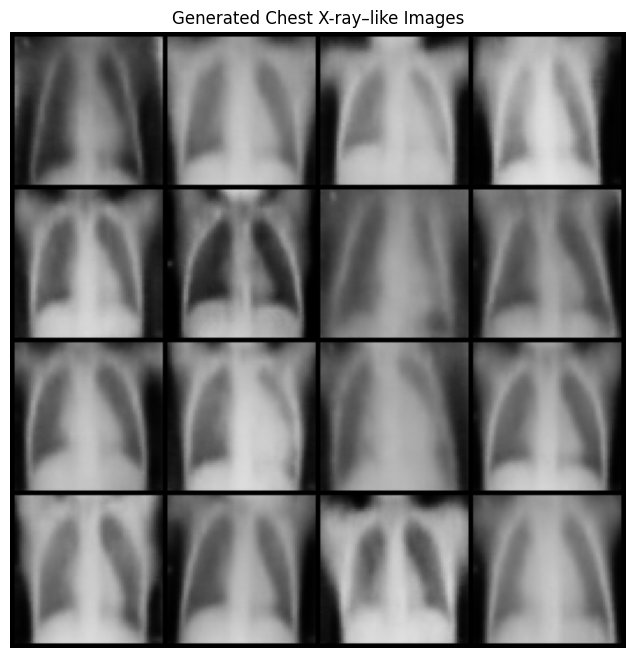

In [41]:
num_samples = 16
latent_dim = model.fc_mu.out_features

z = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
  generated = model.decoder(model.fc_decode(z))

grid = torchvision.utils.make_grid(generated.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated Chest X-ray–like Images")
plt.show()

In [17]:
output_dir = "generated_samples"
os.makedirs(output_dir, exist_ok=True)

model.eval()
num_images = 500    
latent_dim = model.fc_mu.out_features
with torch.no_grad():
    for i in range(num_images):
        z = torch.randn(1, latent_dim).to(device)
        img = model.decoder(model.fc_decode(z))
        save_image(img.cpu(), f"{output_dir}/img_{i:04d}.png")

In [18]:
real_dir = "real_samples"
os.makedirs(real_dir, exist_ok=True)

num_real = 500
count = 0
for x, _ in test_loader:
    for i in range(x.size(0)):
        if count >= num_real:
            break
        save_image(x[i], f"{real_dir}/real_{count:04d}.png")
        count += 1
    if count >= num_real:
        break

In [19]:
fid = fid_score.calculate_fid_given_paths([real_dir, output_dir],
                                          batch_size=32,
                                          device=device,
                                          dims=2048)
print("FID:", fid)

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


FID: 260.2322818274257


In [20]:
class GeneratedDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.endswith(".png")])
        self.transform = Compose([
            Resize(299),  
            CenterCrop(299),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            Normalize([0.5]*3, [0.5]*3)
        ])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("L")
        return self.transform(img)

In [21]:
generated_dataset = GeneratedDataset(output_dir)
generated_loader = DataLoader(generated_dataset, batch_size=32, shuffle=False)

isc = InceptionScore(normalize=True, splits=10).to(device)

for batch in tqdm(generated_loader, desc="Computing IS"):
    isc.update(batch.to(device)) 

mean, std = isc.compute()
print(f"Inception Score: {mean:.3f} ± {std:.3f}")

/Users/teoi/Documents/ece285-hw2/venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Computing IS:   0%|          | 0/16 [00:00<?, ?it/s]

Inception Score: 1.760 ± 0.100


In [ ]:
model = VanillaVAE(latent_dim=16)
dummy_input = torch.randn(1, 1, 64, 64)
torch.onnx.export(model, dummy_input, "vae_encoder.onnx", input_names=["input"], output_names=["mu"])